# Bandwidth search

To find out the optimal bandwidth, `gwlearn` provides a `BandwidthSearch` class, which trains models on a range of bandwidths and selects the most optimal one.

In [11]:
import geopandas as gpd
from geodatasets import get_path

from gwlearn.linear_model import GWLinearRegression, GWLogisticRegression
from gwlearn.search import BandwidthSearch

Get sample data

In [2]:
gdf = gpd.read_file(get_path("geoda.ncovr")).to_crs(5070)

gdf["point"] = gdf.representative_point()
gdf = gdf.set_geometry("point")

y = gdf["FH90"]
X = gdf.iloc[:, 9:15]

## Interval search

Interval search tests the model at a set interval.

In [3]:
search = BandwidthSearch(
    GWLinearRegression,
    fixed=False,
    n_jobs=-1,
    search_method="interval",
    min_bandwidth=50,
    max_bandwidth=1000,
    interval=100,
    criterion="aicc",
    verbose=True,
)
search.fit(
    X,
    y,
    geometry=gdf.geometry,
)

Bandwidth: 50.00, aicc: 15666.353
Bandwidth: 150.00, aicc: 15498.936
Bandwidth: 250.00, aicc: 15660.999
Bandwidth: 350.00, aicc: 15775.129
Bandwidth: 450.00, aicc: 15854.287
Bandwidth: 550.00, aicc: 15918.673
Bandwidth: 650.00, aicc: 15975.564
Bandwidth: 750.00, aicc: 16031.276
Bandwidth: 850.00, aicc: 16080.155
Bandwidth: 950.00, aicc: 16126.986


The `scores_` series then contains the AICc, selected as the criterion, which can be plotted to see the change of the model performance as the bandwidth grows.

<Axes: >

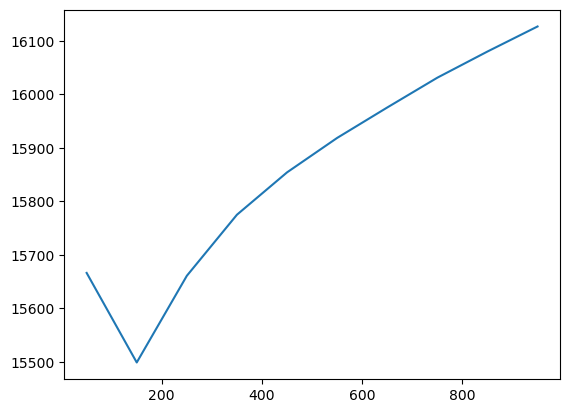

In [4]:
search.scores_.plot()

The optimal bandwidth is then the lowest one.

In [5]:
search.optimal_bandwidth_

np.int64(150)

## Golden section

Alternatively, you can try to use the golden section algorithm that attempts to find the optimal bandwidth iteratively. However, note that there's no guaratnee that it will find the globally optimal bandwidth as it may stick to the local minimum.

In [6]:
search = BandwidthSearch(
    GWLinearRegression,
    fixed=True,
    n_jobs=-1,
    search_method="golden_section",
    criterion="aicc",
    min_bandwidth=250_000,
    max_bandwidth=2_000_000,
    verbose=True,
)
search.fit(
    X,
    y,
    geometry=gdf.geometry,
)

Bandwidth: 918447.5, score: 16135.833
Bandwidth: 1331552.5, score: 16367.508
Bandwidth: 663120.61, score: 15901.394
Bandwidth: 505326.89, score: 15734.258
Bandwidth: 407799.68, score: 15644.228
Bandwidth: 347527.21, score: 15599.261
Bandwidth: 310274.74, score: 15585.033
Bandwidth: 287252.47, score: 15579.996
Bandwidth: 273023.14, score: 15583.440
Bandwidth: 296045.75, score: 15580.453
Bandwidth: 281817.09, score: 15580.952
Bandwidth: 290610.83, score: 15579.452
Bandwidth: 292686.98, score: 15579.549
Bandwidth: 289328.29, score: 15579.566
Bandwidth: 291404.06, score: 15579.440
Bandwidth: 291893.95, score: 15579.458
Bandwidth: 291100.94, score: 15579.438


You can see how the agorithm searches and iteratively gets closer to the optimum.

In [7]:
search.optimal_bandwidth_

np.float64(291100.9431339667)

## Other metrics

By default, `BandwidthSearch` computes AICc, AIC and BIC, available through `metrics_`.

In [8]:
search.metrics_

,aicc,aic,bic
9.184475e+05,16135.832631,16132.605473,16556.503755
1.331552e+06,16367.507618,16366.574492,16597.123551
6.631206e+05,15901.393868,15891.545192,16623.552420
5.053269e+05,15734.258373,15708.559009,16874.775997
4.077997e+05,15644.228226,15588.888391,17273.283311
3.475272e+05,15599.260550,15500.960777,17709.892539
3.102747e+05,15585.032697,15436.700466,18110.784586
2.872525e+05,15579.995539,15383.747794,18423.649729
2.730231e+05,15583.440146,15347.827157,18650.241701
2.960457e+05,15580.452736,15404.583147,18296.148267


You can also ask for a log loss and even use it as a criterion for the selection. This is useful when comparing classification models with varying prediction rate (you can also retrieve that for each bandwidth).

In [12]:
search = BandwidthSearch(
    GWLogisticRegression,
    fixed=False,
    n_jobs=-1,
    search_method="interval",
    min_bandwidth=50,
    max_bandwidth=1000,
    interval=100,
    metrics=["log_loss", "prediction_rate"],
    criterion="log_loss",
    verbose=True,
)
search.fit(
    X,
    y > y.median(),  # simulate binary categorical variable
    geometry=gdf.geometry,
)

Bandwidth: 50.00, log_loss: 0.274
Bandwidth: 150.00, log_loss: 0.372
Bandwidth: 250.00, log_loss: 0.397
Bandwidth: 350.00, log_loss: 0.405
Bandwidth: 450.00, log_loss: 0.400
Bandwidth: 550.00, log_loss: 0.396
Bandwidth: 650.00, log_loss: 0.391
Bandwidth: 750.00, log_loss: 0.392
Bandwidth: 850.00, log_loss: 0.387
Bandwidth: 950.00, log_loss: 0.386


Log loss is then part of the metrics.

In [13]:
search.metrics_

,aicc,aic,bic,log_loss,prediction_rate
50,2889.818542,2358.134113,5833.725640,0.273673,0.664830
150,2206.259163,2148.244589,3527.004346,0.371802,0.726094
250,2157.749410,2136.089862,3015.383346,0.397102,0.746840
350,2200.114858,2188.636740,2856.824897,0.405179,0.783144
450,2254.996420,2247.570704,2810.703657,0.400438,0.831767
550,2278.686205,2273.488677,2758.682537,0.395771,0.863533
650,2309.635433,2305.818659,2733.726039,0.390566,0.896921
750,2386.715455,2383.696709,2775.134682,0.391591,0.932253
850,2430.644557,2428.204092,2789.496584,0.386952,0.966613
950,2498.057834,2495.967664,2838.465899,0.386135,1.000000


And is reported directly as score as it is set as the criterion.

<Axes: >

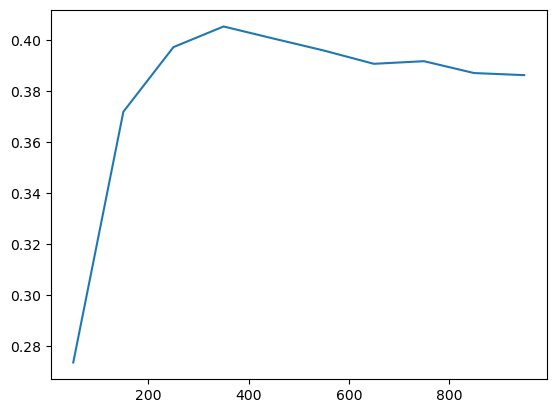

In [14]:
search.scores_.plot()

As a result, the optimal bandwidth is derived directly from it.

In [15]:
search.optimal_bandwidth_

np.int64(50)